In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv('iris.csv')
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [6]:
iris.drop('Id',axis=1,inplace=True)

## *DT FROM SCRATCH*

In [12]:
class Node:
    def __init__(self, feature_index=None, threshold=None,
                left=None, right=None,info_gain=None,value=None):
        # decision node atributes
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        # leaf node attribute
        self.value = value

class DecisionTreeClassifier_scratch:
    def __init__(self,min_samples_split=2,max_depth=2,mode='gini'):

        # initializing the root of the tree
        # tge root will be used to traverse through the tree
        self.root = None
        self.mode = mode

        # stopping conditions
        # if number of samples is less than min_samples_split 
        #       then consider it as leaf node (no more splitting)

        self.min_samples_split=min_samples_split

        # if depth reaches the max_depth then dont split the tree further
        self.max_depth=max_depth

    def build_tree(self,data,curr_depth=0):
        # Build the tree recursively
        #   all rows and columns from starting index to secondlast index
        X = data[:,:-1] # trainig features
        y = data[:,-1] # (target) feature to be classified 
        no_samples, no_features = np.shape(X) # number of samples , number of features

        # split untill stopping conditions are met
        if no_samples >=self.min_samples_split and curr_depth <= self.max_depth:
            # find the best split
            # best split is a dictionary returned by the best_split function
            best_split = self.get_best_split(data, no_samples, no_features)
            #   all rows and last column

            # zero information gain means that node is already pure (leaf), 
            # hence info gain must be positive for spliting

            if best_split['info_gain'] > 0:

                # reursion
                lst = self.build_tree(best_split["left_data"], curr_depth+1)  # left sub tree
                rst = self.build_tree(best_split["right_data"], curr_depth+1) # right sub tree

                return Node(best_split["feature_index"], 
                            best_split["threshold"], 
                            lst, rst, 
                            best_split["info_gain"]) # as its not a leat node we donot pass 'value' 

        # if splitting conditions is not met ... we have reached a leaf node
        # compute leaf value
        leafValue = self.calc_leaf_value(y)
        return Node(value = leafValue)


    def get_best_split(self, data, no_samples, no_features):
        best_split = {}
        max_info_gain = -float('inf') # selected minimum value for max info gain : -ve infinity

        # iterate over all features
        for fi in range(no_features):
            feature_value = data[:,fi]
            possible_thresholds = np.unique(feature_value)
            # threshhold values are real num and 
            # it is practically impossible to iterate through all the threshhold values
            # thus we make a finite list of possible_thresholds
            for th in possible_thresholds:

                # splitting the data into left_data and right_data
                left_data, right_data = self.split(data,fi,th)

                # ensuring that any of the and right_data is not empty
                if len(left_data) > 0 and len(right_data) > 0:
                    y = data[:,-1]
                    left_y = left_data[:,-1]
                    right_y = right_data[:,-1]

                    # computing the info gain based on the mode specified (default gini)
                    curr_info_gain = self.compute_info_gain(y, left_y, right_y, self.mode)

                    # if we get higher information gain than previous then we select that split
                    if curr_info_gain > max_info_gain:
                        best_split['feature_index'] = fi
                        best_split['threshold'] = th
                        best_split['left_data'] = left_data
                        best_split['right_data'] = right_data
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split


    def split(self, data, feature_index, threshold):

        # split the into left child and right child based on threshhold
        left_data = np.array([row for row in data if row[feature_index] <= threshold])
        right_data = np.array([row for row in data if row[feature_index] > threshold])
        return left_data, right_data

    def compute_info_gain(self, parent, left, right, mode='entropy'):
        # computing left weight (wl) & right weight (wr)
        wl = len(left)/len(parent)
        wr = len(right)/len(parent)

        if mode == 'entropy':
            # ig = information gain
            ig = self.entropy(parent) - ( wl*self.entropy(left) + wr*self.entropy(right) )
        else:
            ig = self.gini_index(parent) - ( wl*self.gini_index(left) + wr*self.gini_index(right) )

        return ig

    def entropy(self, y):
        entropy = 0
        labels = np.unique(y) # class labels
        for l in labels:
            p = len(y[y == l]) / len(y)
            entropy += -p * np.log2(p)
        return entropy

    def gini_index(self,y):
        g = 0
        labels = np.unique(y) # class labels
        for l in labels:
            p = len(y[y == l]) / len(y)
            g += p**2
        gi = 1 - g
        return gi

    def calc_leaf_value(self,y):
        y = list(y)
        return max(y, key=y.count)

    def print_tree(self,tree=None,indent="  "):
        if not tree:
            tree = self.root
        if tree.value is not None: # print value of leaf node
            print(tree.value)

        else:
            print(f"X_ {tree.feature_index} <=  {tree.threshold} ? Info gain = {tree.info_gain}")
            print(f"{indent}left:",end='')
            self.print_tree(tree.left, indent+indent)
            print(f"{indent}right:",end='')
            self.print_tree(tree.right, indent+indent)

    def fit(self, X, y):
        data = np.concatenate((X,y),axis=1)
        self.root = self.build_tree(data)

    def predict(self,X):
        # predict set of values
        predictions = [self.make_predictions(x, self.root) for x in X]
        return np.array(predictions).reshape(-1,1)

    def make_predictions(self,x,tree):
        # to predict a single data point

        if tree.value != None: # leaf node
            return tree.value 
        feature_val = x[tree.feature_index] # extracting feature value at a giveb feature index
        if feature_val <= tree.threshold:
            return self.make_predictions(x,tree.left)
        else:
            return self.make_predictions(x,tree.right)        

In [13]:
from sklearn.model_selection import train_test_split
X = iris.iloc[:,:-1].values
y = iris.iloc[:,-1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [35]:
model = DecisionTreeClassifier_scratch(min_samples_split=2, max_depth=3, mode='gini')
model.fit(X_train,y_train)
model.print_tree()

X_ 2 <=  1.9 ? Info gain = 0.3298816872427983
  left:Iris-setosa
  right:X_ 3 <=  1.6 ? Info gain = 0.3832877944691655
    left:X_ 2 <=  4.9 ? Info gain = 0.13999999999999996
        left:Iris-versicolor
        right:X_ 0 <=  6.0 ? Info gain = 0.11999999999999983
                left:Iris-virginica
                right:Iris-virginica
    right:X_ 2 <=  4.8 ? Info gain = 0.011005353955978708
        left:X_ 1 <=  3.0 ? Info gain = 0.375
                left:Iris-virginica
                right:Iris-versicolor
        right:Iris-virginica


In [36]:
from sklearn.metrics import accuracy_score

In [37]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [38]:
test_acc = accuracy_score(y_test, y_pred_test)*100
train_acc = accuracy_score(y_train, y_pred_train)*100

In [39]:
print(f"train accuracy {train_acc}%")
print(f"test accuracy {test_acc}%")

train accuracy 99.16666666666667%
test accuracy 96.66666666666667%


## *Random forest*

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

test_acc = accuracy_score(y_test, y_pred_test)*100
train_acc = accuracy_score(y_train, y_pred_train)*100

print(f"train accuracy {train_acc}%")
print(f"test accuracy {test_acc}%")

<ipython-input-41-884d89bd1594>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)


train accuracy 100.0%
test accuracy 96.66666666666667%


In [48]:
from sklearn.tree import DecisionTreeClassifier 

In [59]:
iris_model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)
iris_model.fit(X_train,y_train)

train_pred = iris_model.predict(X_train)
test_pred = iris_model.predict(X_test)

In [60]:
# train accuracy
accuracy_score(y_train, train_pred)

1.0

In [61]:
accuracy_score(y_test, test_pred)

0.9666666666666667

In [62]:
train_acc_list = []
test_acc_list = []
# depth from 2 to 20
depths = range(1,21)
for depth in depths:
    # make model (of required depth) and fit that model
    model = DecisionTreeClassifier(max_depth=depth)
    model = model.fit(X_train, y_train)

    # predict train and test labels
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # calc accuracy of train and test and keep appending in seperate lists
    train_acc_list.append( accuracy_score(y_train, y_pred_train) )
    test_acc_list.append( accuracy_score(y_test, y_pred_test) )

In [63]:
print(train_acc_list)
print(test_acc_list)

[0.6916666666666667, 0.9583333333333334, 0.9833333333333333, 0.9916666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667]


In [57]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

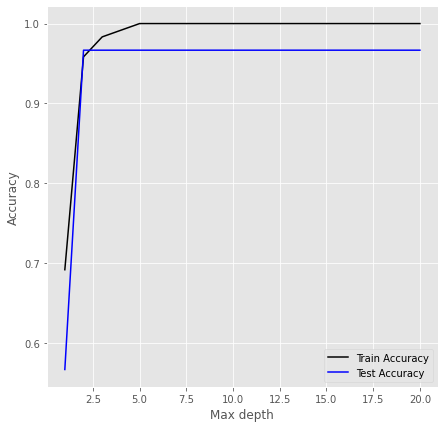

In [64]:
depth_list = range(1,21)
fig = plt.figure(figsize=(7,7))

plt.plot(depth_list, train_acc_list, label='Train Accuracy', color='black')
plt.plot(depth_list, test_acc_list, label='Test Accuracy', color='blue')

plt.xlabel('Max depth')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [42]:
iris.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

### feature importance

In [47]:
feature_imp = pd.Series(rf.feature_importances_, index = iris.columns[:-1])
feature_imp.sort_values(ascending=False)

PetalLengthCm    0.476940
PetalWidthCm     0.366544
SepalLengthCm    0.124420
SepalWidthCm     0.032097
dtype: float64

## *Random forest from scratch*

In [ ]:
def Random_forest(train, test, max_depth, )

## sonar dataset

In [66]:
sr = pd.read_csv("sonar.csv")
sr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.0200  207 non-null    float64
 1   0.0371  207 non-null    float64
 2   0.0428  207 non-null    float64
 3   0.0207  207 non-null    float64
 4   0.0954  207 non-null    float64
 5   0.0986  207 non-null    float64
 6   0.1539  207 non-null    float64
 7   0.1601  207 non-null    float64
 8   0.3109  207 non-null    float64
 9   0.2111  207 non-null    float64
 10  0.1609  207 non-null    float64
 11  0.1582  207 non-null    float64
 12  0.2238  207 non-null    float64
 13  0.0645  207 non-null    float64
 14  0.0660  207 non-null    float64
 15  0.2273  207 non-null    float64
 16  0.3100  207 non-null    float64
 17  0.2999  207 non-null    float64
 18  0.5078  207 non-null    float64
 19  0.4797  207 non-null    float64
 20  0.5783  207 non-null    float64
 21  0.5071  207 non-null    float64
 22  0.